# Probabilistic flood risk assessment

In this notebook, we combine the forecasting abilities and the time series analysis capabilities in a single seamless process to estimate the flood risk of a probabilistic forecast. As an example, we first perform a frequency analysis on an observed time series, then estimate the streamflow associated to a 2-year return period. We then perform a climatological ESP forecast (to ensure repeatability, but a realtime forecast would work too!) and estimate the probability of flooding (exceeding the threshold) given the ensemble of members in the probabilistic forecast.

In [1]:
%matplotlib inline

import datetime as dt

import xclim
from matplotlib import pyplot as plt

from ravenpy.utilities.testdata import get_file, open_dataset

/home/tjs/mambaforge/envs/RavenPy/lib/python3.10/site-packages/xclim/indices/fire/_cffwis.py:207: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _day_length(lat: int | float, mth: int):  # pragma: no cover
/home/tjs/mambaforge/envs/RavenPy/lib/python3.10/site-packages/xclim/indices/fire/_cffwis.py:227: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _day_le

Perform the time series analysis on observed data for the catchment using the frequency analysis WPS capabilities.

In [2]:
# Get the data that we will be using for the demonstration.
file = "raven-gr4j-cemaneige/Salmon-River-Near-Prince-George_meteo_daily.nc"
ts = open_dataset(file).qobs

# Perform the frequency analysis for various return periods. We compute 2, 5, 10, 25, 50 and 100 year return
# periods, but later on we will only compare the forecasts to the 2 year return period.
out = xclim.generic.return_level(
    ts, mode="max", t=(2, 5, 10, 25, 50, 100), dist="gumbel_r"
)
out

<xarray.DataArray 'fa_1maxannual' (return_period: 6)>
array([186.42526386, 283.04234564, 347.01126071, 427.83615447,
       487.79667785, 547.31446213])
Coordinates:
  * return_period  (return_period) int64 2 5 10 25 50 100
Attributes:
    units:               m**3 s**-1
    original_long_name:  discharge observation
    long_name:           N-year return level
    description:         Frequency analysis for the maximal annual 1-day valu...
    method:              ML
    estimator:           Maximum likelihood
    scipy_dist:          gumbel_r
    history:             [2023-05-29 12:29:59] fa_1maxannual: xclim.core.indi...
    cell_methods:        
    mode:                max

Threshold: 186.4


Text(25, 10, 'Flow threshold, set at 2-year return period')

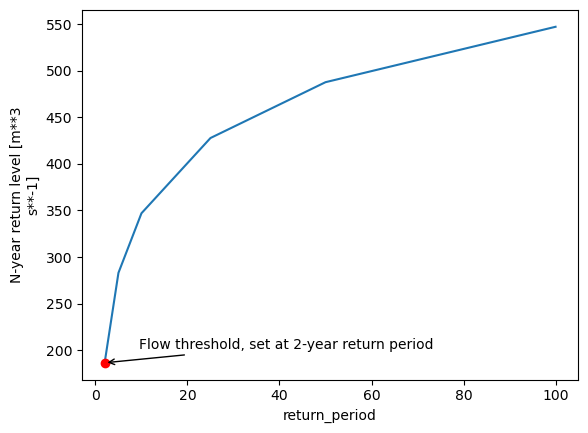

In [3]:
# Plot the results of the flows as a function of return period.
fig, ax = plt.subplots(1)
lines = out.plot(ax=ax)

# Get 2-year return period from the frequency analysis
threshold = out.sel(return_period=2).values
print(f"Threshold: {threshold:.1f}")

pt = ax.plot([2], [threshold], "ro")

ax.annotate(
    "Flow threshold, set at 2-year return period",
    (2, threshold),
    xytext=(25, 10),
    textcoords="offset points",
    arrowprops=dict(arrowstyle="->", connectionstyle="arc3"),
)

## Probabilistic forecast

In this example, we will perform an ensemble hydrological forecast and will then compute the probability of flooding given a flooding threshold. Start by building the model configuration as in the Tutorial Notebook 11:

In [ ]:
from ravenpy.config import commands as rc
from ravenpy.config.emulators import GR4JCN
from ravenpy.utilities.forecasting import climatology_esp, compute_forecast_flood_risk

# Choose the forecast date. Each forecast will start with the same day and month.
# For example, jan-05-2001 will compare the climatology using all jan-05ths from the dataset)
fdate = dt.datetime(2003, 4, 13)

# The dataset to use to get the forecast timeseries:
duration = 30  # Length in days of the climatological ESP forecast

# Define HRU to build the hydrological model
hru = dict(
    area=4250.6,
    elevation=843.0,
    latitude=54.4848,
    longitude=-123.3659,
    hru_type="land",
)

# Set alternative names for netCDF variables
alt_names = {
    "TEMP_MIN": "tmin",
    "TEMP_MAX": "tmax",
    "RAINFALL": "rain",
    "SNOWFALL": "snow",
}

# Data types to extract from netCDF
data_type = ["TEMP_MAX", "TEMP_MIN", "RAINFALL", "SNOWFALL"]
data_kwds = {
    "ALL": {
        "elevation": hru[
            "elevation"
        ],  # No need for lat/lon as they are included in the netcdf file already
    }
}
# Model configuration
model_config = GR4JCN(
    params=[0.529, -3.396, 407.29, 1.072, 16.9, 0.947],
    Gauge=[
        rc.Gauge.from_nc(
            get_file(file),
            data_type=data_type,
            alt_names=alt_names,
            data_kwds=data_kwds,
        )
    ],
    HRUs=[hru],
    StartDate=fdate,
    Duration=duration,
    RunName="Probabilistic_flood_risk_NB",
)

/home/tjs/mambaforge/envs/RavenPy/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Now that the configuration is ready, launch the ESP forecasting tool to generate an ensemble hydrological forecast:

In [ ]:
# Launch the ESP forecasting method
ESP_sims = climatology_esp(
    config=model_config,
)

# Show the results in an xarray dataset, ready to use:
ESP_sims.hydrograph

In [ ]:
# Plot the forecasts and the 2-year threshold previously estimated
fig, ax = plt.subplots(1)
ESP_sims.hydrograph.q_sim[:, :, 0].plot.line(
    ax=ax, hue="member", add_legend=False, color="gray", lw=0.5
)
t = ax.axhline(threshold, color="red")

In [ ]:
# Now compute the flood risk given the probabilistic forecast and the threshold associated to the 2-year return
# period.

threshold = out.sel(return_period=2).values

# Run the flood forecast risk tool to extract the probability of exceedance in netcdf format and xarray Dataset format
flood_risk_data = compute_forecast_flood_risk(
    forecast=ESP_sims.hydrograph.q_sim,
    flood_level=threshold,
)

# Extract the data and plot
fig, ax = plt.subplots(1)
l = flood_risk_data.exceedance_probability.plot()
ax.set_ylabel("Flood risk")

### Results analysis
We can see from the above figure that there is no risk of exceeding the 2-year return period for the selected dates of the forecast.
